# 작동 테스트

In [2]:
import argparse
import time
import torch
import torch.nn.parallel
from contextlib import suppress

from effdet import create_model, create_evaluator, create_dataset, create_loader
from effdet.data import resolve_input_config
from timm.utils import AverageMeter, setup_default_logging
from timm.models.layers import set_layer_config

from matplotlib import pyplot as plt # for visualization
import matplotlib.patches as patches
import numpy as np
import warnings
from PIL import Image
from torchvision.ops.boxes import batched_nms


warnings.filterwarnings(action='ignore')

has_apex = False
try:
    from apex import amp
    has_apex = True
except ImportError:
    pass

has_native_amp = False
try:
    if getattr(torch.cuda.amp, 'autocast') is not None:
        has_native_amp = True
except AttributeError:
    pass

torch.backends.cudnn.benchmark = True

def add_bool_arg(parser, name, default=False, help=''):  # FIXME move to utils
    dest_name = name.replace('-', '_')
    group = parser.add_mutually_exclusive_group(required=False)
    group.add_argument('--' + name, dest=dest_name, action='store_true', help=help)
    group.add_argument('--no-' + name, dest=dest_name, action='store_false', help=help)
    parser.set_defaults(**{dest_name: default})

In [3]:
parser = argparse.ArgumentParser(description='PyTorch ImageNet Validation')
parser.add_argument('root', metavar='DIR',
                    help='path to dataset root') # 디폴트 데이터셋 파싱
parser.add_argument('--dataset', default='coco', type=str, metavar='DATASET',
                    help='Name of dataset (default: "coco"') 
parser.add_argument('--split', default='val',
                    help='validation split')
parser.add_argument('--model', '-m', metavar='MODEL', default='tf_efficientdet_d1',
                    help='model architecture (default: tf_efficientdet_d1)')
add_bool_arg(parser, 'redundant-bias', default=None,
                    help='override model config for redundant bias layers')
add_bool_arg(parser, 'soft-nms', default=None, help='override model config for soft-nms')
parser.add_argument('--num-classes', type=int, default=None, metavar='N',
                    help='Override num_classes in model config if set. For fine-tuning from pretrained.')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--img-size', default=None, type=int,
                    metavar='N', help='Input image dimension, uses model default if empty')
parser.add_argument('--mean', type=float, nargs='+', default=None, metavar='MEAN',
                    help='Override mean pixel value of dataset')
parser.add_argument('--std', type=float,  nargs='+', default=None, metavar='STD',
                    help='Override std deviation of of dataset')
parser.add_argument('--interpolation', default='bilinear', type=str, metavar='NAME',
                    help='Image resize interpolation type (overrides model)')
parser.add_argument('--fill-color', default=None, type=str, metavar='NAME',
                    help='Image augmentation fill (background) color ("mean" or int)')
parser.add_argument('--log-freq', default=10, type=int,
                    metavar='N', help='batch logging frequency (default: 10)')
parser.add_argument('--checkpoint', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--num-gpu', type=int, default=1,
                    help='Number of GPUS to use')
parser.add_argument('--no-prefetcher', action='store_true', default=False,
                    help='disable fast prefetcher')
parser.add_argument('--pin-mem', action='store_true', default=False,
                    help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
parser.add_argument('--use-ema', dest='use_ema', action='store_true',
                    help='use ema version of weights if present')
parser.add_argument('--amp', action='store_true', default=False,
                    help='Use AMP mixed precision. Defaults to Apex, fallback to native Torch AMP.')
parser.add_argument('--apex-amp', action='store_true', default=False,
                    help='Use NVIDIA Apex AMP mixed precision')
parser.add_argument('--native-amp', action='store_true', default=False,
                    help='Use Native Torch AMP mixed precision')
parser.add_argument('--torchscript', dest='torchscript', action='store_true',
                    help='convert model torchscript for inference')
parser.add_argument('--results', default='', type=str, metavar='FILENAME',
                    help='JSON filename for evaluation results')
parser.add_argument('--num-partition',type=int,default=1,
                    help='Number of partition')

_StoreAction(option_strings=['--num-partition'], dest='num_partition', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help='Number of partition', metavar=None)

In [4]:
def visualization(output,file_number:int, num_tile:int, gt:bool = False):
  # ############################
  # visualization aggregation
  # ############################
  '''
  file_number : must be cpu integer
  '''
  
  colors = ['red','blue','purple']
  fig, ax = plt.subplots()
  if gt == True:
    
    img_scale = output['img_scale']
    output = output['bbox'][0]
    output *= img_scale
    for bi in range(len(output)):
      box = output[bi]
      b = np.array(box.cpu())
      ax.add_patch(
        patches.Rectangle(
          # 좌표변경 yxyx -> xywh
          (b[1],b[0]),b[3]-b[1] ,b[2]-b[0] , edgecolor = 'red', fill=False)
      )
  else:
    for bi in range(len(output)): # num of box
      box = output[bi]
      b = np.array(box.cpu())
      color_index = int(b[6])
      
      color_index = color_index//int(np.sqrt(num_tile)) + color_index%int(np.sqrt(num_tile)) 
      if color_index%2 ==0:
        color_index = 0
      else:
        color_index = 1

      if color_index ==-1: # integ만 확인
        linewidth=2
      else:
        linewidth=1
      ax.add_patch(
        patches.Rectangle(
          # 좌표변경 xyxy -> xywh
          (b[0],b[1]),b[2]-b[0] ,b[3]-b[1] , edgecolor = colors[color_index], fill=False,linewidth = linewidth)
      
      )
      
  file_number = str(file_number)
  
  #file_name = '0'*(12-len(file_number))+file_number
  img = Image.open('data_air/images/'+file_number+'.jpg')
  ax.imshow(img)

In [5]:
def aggregation(width,height,num_gpu,output,overlap_ratio = 0.25):
  # #########################################
  # aggregation
  # #########################################
  n_tile = int(np.sqrt(num_gpu))

  
  #분할된 조각(오버랩 포함)
  sub_width = torch.tensor(width/(overlap_ratio*(1-n_tile)+n_tile),dtype=int)
  sub_height = torch.tensor(height/(overlap_ratio*(1-n_tile)+n_tile),dtype=int)

  #output : [batch*num_gpu,40,6]
  batch_size = int(output.size()[0]/num_gpu)
  num_det_img = output.size()[1]

  #분할된 조각(오버랩 미포함)
  sub_width_ = torch.tensor(width/n_tile,dtype=int)
  sub_height_ = torch.tensor(height/n_tile,dtype=int)
  
  outputs = list(torch.split(output,batch_size,dim=0))
  # outputs [num_gpu,batch_size,40,6]

  full_output=outputs[0] # 여기에 더해나가기 


  for i in range(n_tile):
    for j in range(n_tile):
      ext_width = sub_width_*j 
      if j!=0:
        ext_width -= (sub_width-sub_width_) #차이만큼을 빼주기
      ext_height = sub_height_*i
      if i!=0:
        ext_height -= (sub_height-sub_height_)

      # [batch,1]
      ext_width = ext_width.unsqueeze(dim=1) 
      ext_height = ext_height.unsqueeze(dim=1) 
      
      # [batch, 1,1]
      ext_width = torch.cat([ext_width for _ in range(num_det_img)],dim=1)
      ext_height = torch.cat([ext_height for _ in range(num_det_img)],dim=1)
      # [batch, 40,1]
      n = i*n_tile+j
    
      if j==0: 
        ext_width =0
      if i==0: 
        ext_height =0
      outputs[n] = torch.cat([outputs[n][:,:,:1]+ext_width,
                              outputs[n][:,:,1:2]+ext_height,
                              outputs[n][:,:,2:3]+ext_width,
                              outputs[n][:,:,3:4]+ext_height,
                              outputs[n][:,:,4:]],dim=2)
      
      if j!=0 or i!=0:
        full_output= torch.cat((full_output,outputs[n]),dim=1)
  
  # partition index 추가
  gpu_index = torch.zeros([batch_size,num_det_img*num_gpu,1],device='cuda:0')
  for i in range(num_gpu):
    gpu_index[:,i*num_det_img : (i+1)*num_det_img,:] = i

  full_output = torch.cat([full_output,gpu_index],dim=2)
  return full_output

In [6]:
def nms(full_output,max_det_per_image=100):

  boxes = full_output[0,:,:4]
  scores = full_output[0,:,4:5].squeeze(dim=1)
  classes = full_output[0,:,5:6].squeeze(dim=1)
  gpu_index = full_output[0,:,6:].squeeze(dim=1)

  top_detection_idx = batched_nms(boxes, scores, classes, iou_threshold=0.5)
  top_detection_idx = top_detection_idx[:max_det_per_image]
  boxes = boxes[top_detection_idx]
  scores = scores[top_detection_idx,None]
  classes = classes[top_detection_idx,None]
  gpu_index = gpu_index[top_detection_idx,None]
  detections = torch.cat([boxes,scores,classes.float(),gpu_index],dim=1)
  num_det = len(top_detection_idx)
  if num_det < max_det_per_image:
        detections = torch.cat([
            detections,
            torch.zeros((max_det_per_image - num_det, 7), device=detections.device, dtype=detections.dtype)
        ], dim=0)
  return detections



In [7]:
def overlap_nms(full_output,width,height,overlap_ratio = 0.25):
  

  def _upcast(t) :
    # Protects from numerical overflows in multiplications by upcasting to the equivalent higher type
    if t.is_floating_point():
        return t if t.dtype in (torch.float32, torch.float64) else t.float()
    else:
        return t if t.dtype in (torch.int32, torch.int64) else t.int()
  
  def box_area(boxes):
    """
    Computes the area of a set of bounding boxes, which are specified by their
    (x1, y1, x2, y2) coordinates.

    Args:
        boxes (Tensor[N, 4]): boxes for which the area will be computed. They
            are expected to be in (x1, y1, x2, y2) format with
            ``0 <= x1 < x2`` and ``0 <= y1 < y2``.

    Returns:
        Tensor[N]: the area for each box
    """
    boxes = _upcast(boxes)
    return (boxes[2] - boxes[ 0]) * (boxes[3] - boxes[1])
  
  def box_iou(boxes1, boxes2):
    """
    boxes1,boxes2  : tensor ( [N,4] )
    """
    #area1 = box_area(boxes1)
    #area2 = box_area(boxes2)

    lt = torch.max(boxes1[None, :2], boxes2[:2])  # [N,M,2]
    rb = torch.min(boxes1[None, 2:], boxes2[2:])  # [N,M,2]
    
    wh = _upcast(rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[ :, 0] * wh[ :, 1]  # [N,M]

    #union = area1[:, None] + area2 - inter

    #iou = inter/union
    #return iou
    return inter
  def make_new_box(boxes,chosen_boxes):

    b0 = min(boxes[chosen_boxes][:,0])
    b1 = min(boxes[chosen_boxes][:,1])
    b2 = max(boxes[chosen_boxes][:,2])
    b3 = max(boxes[chosen_boxes][:,3])

    return torch.tensor([b0, b1, b2, b3],device='cuda:0')
  
  def overlap(boxes,scores,classes, gpu_index, width, height, overlap_ratio):

    # [M, N], M is selected box
    
    sorted_index = torch.argsort(classes,dim=0,descending=True)
    boxes = boxes[sorted_index].squeeze(dim=1)
    scores = scores[sorted_index].squeeze(dim=1)
    classes = classes[sorted_index].squeeze(dim=1)
    gpu_index = gpu_index[sorted_index].squeeze(dim=1)

    slack = 10
    st_flag = 0
    while len(boxes):
      chosen_boxes = [-1 for _ in range(4)] # 선택박스 그룹, 4는 파티션 수
      chosen_boxes[int(gpu_index[0][0])] = 0 # 첫번째 box 입력, index로 관리

      for box_index in range(len(boxes)):
        # 같은 파티션이 아니고 유사한 위치에 넓이 또는 높이가 유사한 경우 (범위 픽셀), overlap 조건 필요
        if gpu_index[box_index] == gpu_index[0]: #같은 파티션 패스
          continue
        if chosen_boxes[int(gpu_index[box_index][0])] != -1: # 높은스코어부터 결정하기 때문에 이미 존재하면 패스
          continue
        terminate = False
        for chosen_index in chosen_boxes: #위 조건에 안걸리면 box 비교
          if chosen_index==-1: # 비어있는경우
            continue

          if box_iou(boxes[box_index],boxes[chosen_index]) == 0: 
            # overlap 존재안하는경우
            continue
          
          if ((abs(boxes[box_index][0]-boxes[chosen_index][0]) <slack and abs(boxes[box_index][2]-boxes[chosen_index][2]) <slack)\
            or (abs(boxes[box_index][1]-boxes[chosen_index][1]) <slack and abs(boxes[box_index][3]-boxes[chosen_index][3]) <slack))\
              ==False:
            # 유사한 위치에 넓이 또는 높이가 유사하지 않은 경우
            continue
          
          
          # 엄격한 기준, overlap 영역 최대일때만 취합
          lt = torch.max(boxes[box_index][None, :2], boxes[chosen_index][:2])  # [N,M,2]
          rb = torch.min(boxes[box_index][None, 2:], boxes[chosen_index][2:])
          overlap_length = abs(lt-rb)
          if int( abs(gpu_index[box_index][0]-gpu_index[chosen_index][0]) ) ==1:
            if int(abs(overlap_length[0][0] - (2*width/(2-overlap_ratio)-width) ) ) > 10:
              continue
          else:
            if int(abs(overlap_length[0][1] - (2*height/(2-overlap_ratio)-height) ) ) > 10:
              continue
          


          if scores[box_index][0]-scores[chosen_index][0]>0.2:
            terminate = True
            break 
          # 결합할 box의 class score가 0.3 이상 차이날 경우, 이 경우는 아예 제외
          # class score로 정렬되어있기 때문에 밖 루프까지 한번에 종료

          chosen_boxes[int(gpu_index[box_index][0])] = box_index # 선택
          break
        if terminate == True:
          break

      # chosen_boxe에 대해서 클래스별로 가장높은 box 한가지씩만 남기기
      #-1 인것들 제거
      chosen_boxes_f = []
      for i in chosen_boxes:
        if i!=-1:
          chosen_boxes_f.append(i)

      indexes = np.array([i for i in range(len(boxes))])
      indexes = np.delete(indexes,chosen_boxes_f)

      avg_scores = max(scores[chosen_boxes_f])#.mean() # score는 평균내기
      avg_scores = torch.tensor([[avg_scores]],device='cuda:0')
      if len(chosen_boxes_f)>1:
        integrated_num_gpu = torch.tensor([[-1]],device='cuda:0')
      else:
        integrated_num_gpu = torch.tensor(gpu_index[chosen_boxes_f[0]], device='cuda:0').unsqueeze(dim=0)

      integrated_classes = torch.tensor(classes[:1,:1],device='cuda:0')

      if st_flag ==0:
        new_boxes = make_new_box(boxes,chosen_boxes_f)
        new_boxes = new_boxes.unsqueeze(dim=0)
        new_boxes = torch.cat([new_boxes, avg_scores, integrated_classes, integrated_num_gpu],dim=1)
      else: 
        new_box = make_new_box(boxes,chosen_boxes_f)
        new_box = new_box.unsqueeze(dim=0)
        new_box = torch.cat([new_box, avg_scores, integrated_classes, integrated_num_gpu],dim=1)
        new_boxes = torch.cat([new_boxes,new_box],dim=0)
        # 기존 box 제거 안하고 남겨두기
        #temp = torch.cat([boxes[chosen_boxes_f], scores[chosen_boxes_f], classes[chosen_boxes_f], gpu_index[chosen_boxes_f]],dim=1)
        #new_boxes = torch.cat([new_boxes,temp],dim=0)
      
      boxes = boxes[indexes]
      scores = scores[indexes]
      classes = classes[indexes]
      gpu_index = gpu_index[indexes]

      st_flag =1
    return new_boxes

  #full_output = [10,160,7]
  
  boxes = full_output[:,:,:4]
  scores = full_output[:,:,4:5]
  classes = full_output[:,:,5:6]
  gpu_index = full_output[:,:,6:]
  # [batch_size, num_det_img*num_tpu, n]

  batch_size = boxes.size()[0]

  temp_box = []
  for bt in range(batch_size):
    temp = []
    for index, class_id in enumerate(torch.unique(classes[bt])):
      cur_indices = torch.where(classes[bt]==class_id)[0]
      temp.append( overlap(boxes[bt][cur_indices], scores[bt][cur_indices],classes[bt][cur_indices], gpu_index[bt][cur_indices],width,height,overlap_ratio) )
    #print( torch.cat(temp,dim=0).unsqueeze(dim=0).size() )
    temp_box.append( nms( torch.cat(temp,dim=0).unsqueeze(dim=0) ).unsqueeze(dim=0) )
  
  
  new_boxes = torch.cat(temp_box,dim=0)
  return new_boxes
  

In [8]:
def validate(args):
    setup_default_logging()

    if args.amp:
        if has_native_amp:
            args.native_amp = True
        elif has_apex:
            args.apex_amp = True
    assert not args.apex_amp or not args.native_amp, "Only one AMP mode should be set."
    args.pretrained = args.pretrained or not args.checkpoint  # might as well try to validate something
    args.prefetcher = not args.no_prefetcher

    #tile의 개수만큼 생성
    num_tile = args.num_partition
    # overlap ratio
    overlap_ratio = int(args.root[-2:])/100
    print('overlap_ratio',overlap_ratio)
    # create model
    with set_layer_config(scriptable=args.torchscript):
        extra_args = {}
        if args.img_size is not None:
            extra_args = dict(image_size=(args.img_size, args.img_size))
        # img size는 512*512보다 작을경우 패딩
        sub_width = int(2560/( overlap_ratio*(1-int(np.sqrt(num_tile)))+int(np.sqrt(num_tile)) ))
        max_detection_points = int((5000/num_tile)*(sub_width/(2560/int(np.sqrt(num_tile))))**2)
        max_det_per_image = int((100/num_tile)*(sub_width/(2560/int(np.sqrt(num_tile))))**2)
        print('max_detection_points',max_detection_points)
        print('max_det_per_image',max_det_per_image)
        extra_args = dict(max_detection_points = max_detection_points, max_det_per_image =max_det_per_image) #분할 이미지 크기, 0.25 overlap일 경우
        #extra_args = dict(max_detection_points = )

        bench = create_model(
            args.model,
            bench_task='predict',
            num_classes=args.num_classes,
            pretrained=args.pretrained,
            redundant_bias=args.redundant_bias,
            soft_nms=args.soft_nms,
            checkpoint_path=args.checkpoint,
            checkpoint_ema=args.use_ema,
            **extra_args,
        )
    model_config = bench.config

    param_count = sum([m.numel() for m in bench.parameters()])
    print('Model %s created, param count: %d' % (args.model, param_count))

    bench = bench.cuda()

    amp_autocast = suppress
    if args.apex_amp:
        bench = amp.initialize(bench, opt_level='O1')
        print('Using NVIDIA APEX AMP. Validating in mixed precision.')
    elif args.native_amp:
        amp_autocast = torch.cuda.amp.autocast
        print('Using native Torch AMP. Validating in mixed precision.')
    else:
        print('AMP not enabled. Validating in float32.')

    #''' custom module test
    if args.num_gpu > 1:
        bench = torch.nn.DataParallel(bench, device_ids=list(range(args.num_gpu)))
    #'''

    #print('@@debug@@: ',args.dataset,args.root,args.split) # 디버그 : split_coco, data/split, val

    datasets=[] # 분산 데이터셋 생성
    
    for i in range(num_tile):
      datasets.append( create_dataset(args.dataset, args.root+'/split_'+str(i), args.split) ) # 데이터셋 생성
    
    input_config = resolve_input_config(args, model_config)

    loaders =  [] # 분산 로더 생성
    for i in range(num_tile):
      loaders.append( create_loader(
          datasets[i],
          input_size=input_config['input_size'],
          batch_size=args.batch_size,
          use_prefetcher=args.prefetcher,
          interpolation=input_config['interpolation'],
          fill_color=input_config['fill_color'],
          mean=input_config['mean'],
          std=input_config['std'],
          num_workers=args.workers,
          pin_mem=args.pin_mem)
          )
    
    
    # ground truth 용 데이터셋, 로더
    gt_dataset = create_dataset(args.dataset,'data_air',args.split)
    
    gt_loader = create_loader(gt_dataset, 
    input_size=input_config['input_size'],
          batch_size=args.batch_size,
          use_prefetcher=args.prefetcher,
          interpolation=input_config['interpolation'],
          fill_color=input_config['fill_color'],
          mean=input_config['mean'],
          std=input_config['std'],
          num_workers=args.workers,
          pin_mem=args.pin_mem)
    gt_loader = iter(gt_loader)
    

    # loader 출력해서 상태살피기
    # 가장 쉬운 방법은 loader를 4개만들어서 출력**
    evaluator = create_evaluator('air', datasets[0], pred_yxyx=False) # evaluator.py
    #첫번째만 사용해서 체크
    
    bench.eval()
    batch_time = AverageMeter()
    end = time.time()
    last_idx = len(loaders[0]) - 1

    for i in range(len(loaders)):
      loaders[i] = iter(loaders[i])
    
    load_time = []
    detect_time = []
    aggregate_time = []
    over_time=[]

    

    with torch.no_grad():
        for i in range(last_idx+1):
            
            time1 = time.time()
            # input 생성
            input, target = next(loaders[0])
            #gt_input, gt_target = next(gt_loader)
            # input [batch,3,512,512]
            # target key 안에 batch 만큼의 value
            # image size
            width = target['img_size'][:args.batch_size,:1]
            height = target['img_size'][:args.batch_size,1:]
            # width, height [batch,1]
            
            # target도 parallel 가능하게 변경
            for key in target.keys():
              temp = target[key]
              for _ in range(1,num_tile):
                temp = torch.cat((temp,target[key]),dim=0)
              target[key] = temp
            
            #print('input:',input.size())
            for n in range(1,num_tile):
              _input,_target = next(loaders[n])
              input = torch.cat( (input, _input), dim=0)
            
            time2 = time.time()


            with amp_autocast():
                output = bench(input , img_info=target) # bench.py DetBenchPredict에서 아웃풋 합치는 것 확인
                #img_info 보낼 경우 scale된 결과 return, eval에서는 이걸 사용해야 할수있음
                #output = bench (input)# visualization에서는 이것
            #print('output:',output.size()) # 4, 40, 6
            
            time3 = time.time()
            # aggregation
            outputs = aggregation(width,height,num_tile,output,overlap_ratio=overlap_ratio)
            
            ### visualization
            
            visualization(outputs[0],int(target['file_name'][0].cpu()),num_tile)
            
            time4 = time.time()

            # overlap box integration
            #outputs = overlap_nms(outputs,width,height,overlap_ratio=overlap_ratio)
            
            
            # test for overlap but non integration
            
            list_output =[]

            for bt in range(args.batch_size):
              list_output.append( nms(outputs[bt:bt+1]).unsqueeze(dim=0) )
            outputs = torch.cat(list_output,dim=0)
            
            time5 = time.time()

            ### visualization
            
            for bt in range(args.batch_size):
              visualization(outputs[bt],int(target['file_name'][bt].cpu()),num_tile)
            

            #eval 에서는 gt_target으로 비교
            gt_input, gt_target = next(gt_loader)
            evaluator.add_predictions(outputs, gt_target)
            
            ### ground truth visualization
            
            visualization(gt_target,int(target['file_name'][0].cpu()),num_tile,gt = True)
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.log_freq == 0 or i == last_idx:
                print(
                    'Test: [{0:>4d}/{1}]  '
                    'Time: {batch_time.val:.3f}s ({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  '
                    .format(
                        i, last_idx+1, batch_time=batch_time,
                        rate_avg=input.size(0) / batch_time.avg)
                )
            
            load_time.append(time2-time1)
            detect_time.append(time3-time2)
            aggregate_time.append(time4-time3)
            over_time.append(time5-time4)
            if i==0:
              break
    print('@@@@@@@@@@@@@@@')
    print('로드', np.mean(load_time))
    print('탐지', np.mean(detect_time[1:]))
    print('취합', np.mean(aggregate_time))
    print('박스처리', np.mean(over_time))
    print('@@@@@@@@@@@@@@@')
    
            
    mean_ap = 0.
    if datasets[0].parser.has_labels:
        mean_ap = evaluator.evaluate(output_result_file=args.results)
    else:
        evaluator.save(args.results)

    return mean_ap
    
    


overlap_ratio 0.0
max_detection_points 1250
max_det_per_image 25
Model tf_efficientdet_d6 created, param count: 51871782
AMP not enabled. Validating in float32.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Metrics:
Metrics:
Metrics:
Metrics:
PascalBoxes_Precision/mAP@0.5IOU: 0.625
PascalBoxes_Precision/mAP@0.5IOU: 0.625
PascalBoxes_Precision/mAP@0.5IOU: 0.625
PascalBoxes_Precision/mAP@0.5IOU: 0.625
PascalBoxes_PerformanceByCategory/AP@0.5IOU/airplane: 0.625
PascalBoxes_PerformanceByCategory/AP@0.5IOU/airplane: 0.625
PascalBoxes_PerformanceByCategory/AP@0.5IOU/airplane: 0.625
PascalBoxes_PerformanceByCategory/AP@0.5IOU/airplane: 0.625


Test: [   0/103]  Time: 19.241s (19.241s,    0.21/s)  
@@@@@@@@@@@@@@@
로드 1.214019536972046
탐지 nan
취합 0.19768381118774414
박스처리 0.0010535717010498047
@@@@@@@@@@@@@@@


0.625

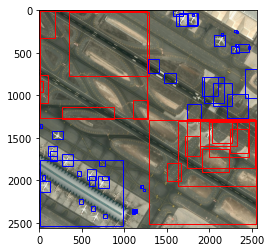

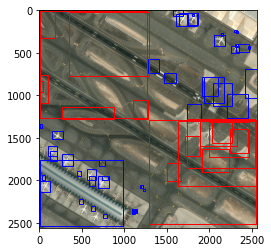

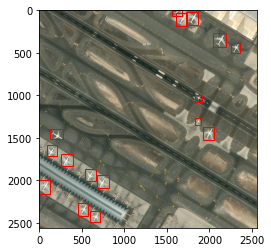

In [12]:
args_str = 'data_air/split_00 --dataset air --model tf_efficientdet_d6 --num-gpu 4 --batch-size 1 --num-partition 4'
#args_str = 'data --model tf_efficientdet_d0 --num-gpu 4'
args,_ = parser.parse_known_args(args=args_str.split())
validate(args)